# Anomaly Detection in time series data

### Necessary Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading and understanding the Data

In [ ]:
# Read the CSV file into a DataFrame
sensor_df = pd.read_csv("/content/drive/My Drive/IDS 575/sensor.csv")
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [ ]:
sensor_df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [ ]:
sensor_df.nunique()

Unnamed: 0        220320
timestamp         220320
sensor_00           1253
sensor_01            831
sensor_02            831
sensor_03            588
sensor_04           7844
sensor_05         190751
sensor_06            812
sensor_07            531
sensor_08            626
sensor_09            565
sensor_10         198804
sensor_11         196368
sensor_12         187145
sensor_13         191983
sensor_14          94564
sensor_15              0
sensor_16         110522
sensor_17         148000
sensor_18         152603
sensor_19         100422
sensor_20          92129
sensor_21         131083
sensor_22         126401
sensor_23         119286
sensor_24         133778
sensor_25         165999
sensor_26         179718
sensor_27         203198
sensor_28         189278
sensor_29         201908
sensor_30           2070
sensor_31           2685
sensor_32         205414
sensor_33         200855
sensor_34         203895
sensor_35         201781
sensor_36         201437
sensor_37         188898


In [ ]:
sensor_df['machine_status'].value_counts(dropna=False).head()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

## Data Cleaning and Preprocessing

We can see that the data needs some cleaning as there are missing values in multiple columns, one of the sensor readings are empty and the timestamp column has incorrect datatype

1.   Remove redundant columns
2.   Remove duplicates
3.   Handle missing values
4.   Convert data types to the correct data type

In [ ]:
# Drop duplicates
sensor_df = sensor_df.drop_duplicates()
sensor_df.shape

(220320, 55)

In [ ]:
# Entire "sensor_15" column is NaN therefore removing the entire column from the data set
del sensor_df['sensor_15']
del sensor_df['Unnamed: 0']

In [ ]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent'])
    idx = nans['percent'] > 0
    nans['percent'] = nans['percent'].apply(lambda x: '{:.2%}'.format(x))
    return nans[idx]

In [ ]:
calc_percent_NAs(sensor_df).head(15)

,percent
sensor_50,34.96%
sensor_51,6.98%
sensor_00,4.63%
sensor_07,2.47%
sensor_08,2.32%
sensor_06,2.18%
sensor_09,2.09%
sensor_01,0.17%
sensor_30,0.12%
sensor_29,0.03%


In [ ]:
# For the sensors that have more then 2% of missing vaues, we will use the mean of the values, the rest we'll drop

sensor_df['sensor_50'].fillna((sensor_df['sensor_50'].mean()), inplace=True)
sensor_df['sensor_51'].fillna((sensor_df['sensor_51'].mean()), inplace=True)
sensor_df['sensor_00'].fillna((sensor_df['sensor_00'].mean()), inplace=True)
sensor_df['sensor_08'].fillna((sensor_df['sensor_07'].mean()), inplace=True)
sensor_df['sensor_07'].fillna((sensor_df['sensor_08'].mean()), inplace=True)
sensor_df['sensor_06'].fillna((sensor_df['sensor_06'].mean()), inplace=True)
sensor_df['sensor_09'].fillna((sensor_df['sensor_09'].mean()), inplace=True)

calc_percent_NAs(sensor_df).head(15)

,percent
sensor_01,0.17%
sensor_30,0.12%
sensor_29,0.03%
sensor_32,0.03%
sensor_18,0.02%
sensor_17,0.02%
sensor_22,0.02%
sensor_25,0.02%
sensor_16,0.01%
sensor_45,0.01%


In [ ]:
Cleaned_df = sensor_df.dropna()
Cleaned_df['date'] = pd.to_datetime(Cleaned_df['timestamp'])
del Cleaned_df['timestamp']

Cleaned_df = Cleaned_df.set_index('date')
Cleaned_df.info()

<ipython-input-112-4b7b67363801>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Cleaned_df['date'] = pd.to_datetime(Cleaned_df['timestamp'])


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219521 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       219521 non-null  float64
 1   sensor_01       219521 non-null  float64
 2   sensor_02       219521 non-null  float64
 3   sensor_03       219521 non-null  float64
 4   sensor_04       219521 non-null  float64
 5   sensor_05       219521 non-null  float64
 6   sensor_06       219521 non-null  float64
 7   sensor_07       219521 non-null  float64
 8   sensor_08       219521 non-null  float64
 9   sensor_09       219521 non-null  float64
 10  sensor_10       219521 non-null  float64
 11  sensor_11       219521 non-null  float64
 12  sensor_12       219521 non-null  float64
 13  sensor_13       219521 non-null  float64
 14  sensor_14       219521 non-null  float64
 15  sensor_16       219521 non-null  float64
 16  sensor_17       219521

## Exploratory Data Analysis

### Overview of the relationship between the sensors

<ipython-input-113-e2f09fed2ef7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_lt = Cleaned_df.corr().where(np.tril(np.ones(Cleaned_df.corr().shape),k=-1).astype(np.bool))
<ipython-input-113-e2f09fed2ef7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_corr_lt = Cleaned_df.corr().where(np.tril(np.ones(Cleaned_df.corr().shape),k=-1).astype(np.bool))


Text(0.5, 1.0, 'Visualizing the correlation between all the sensors:')

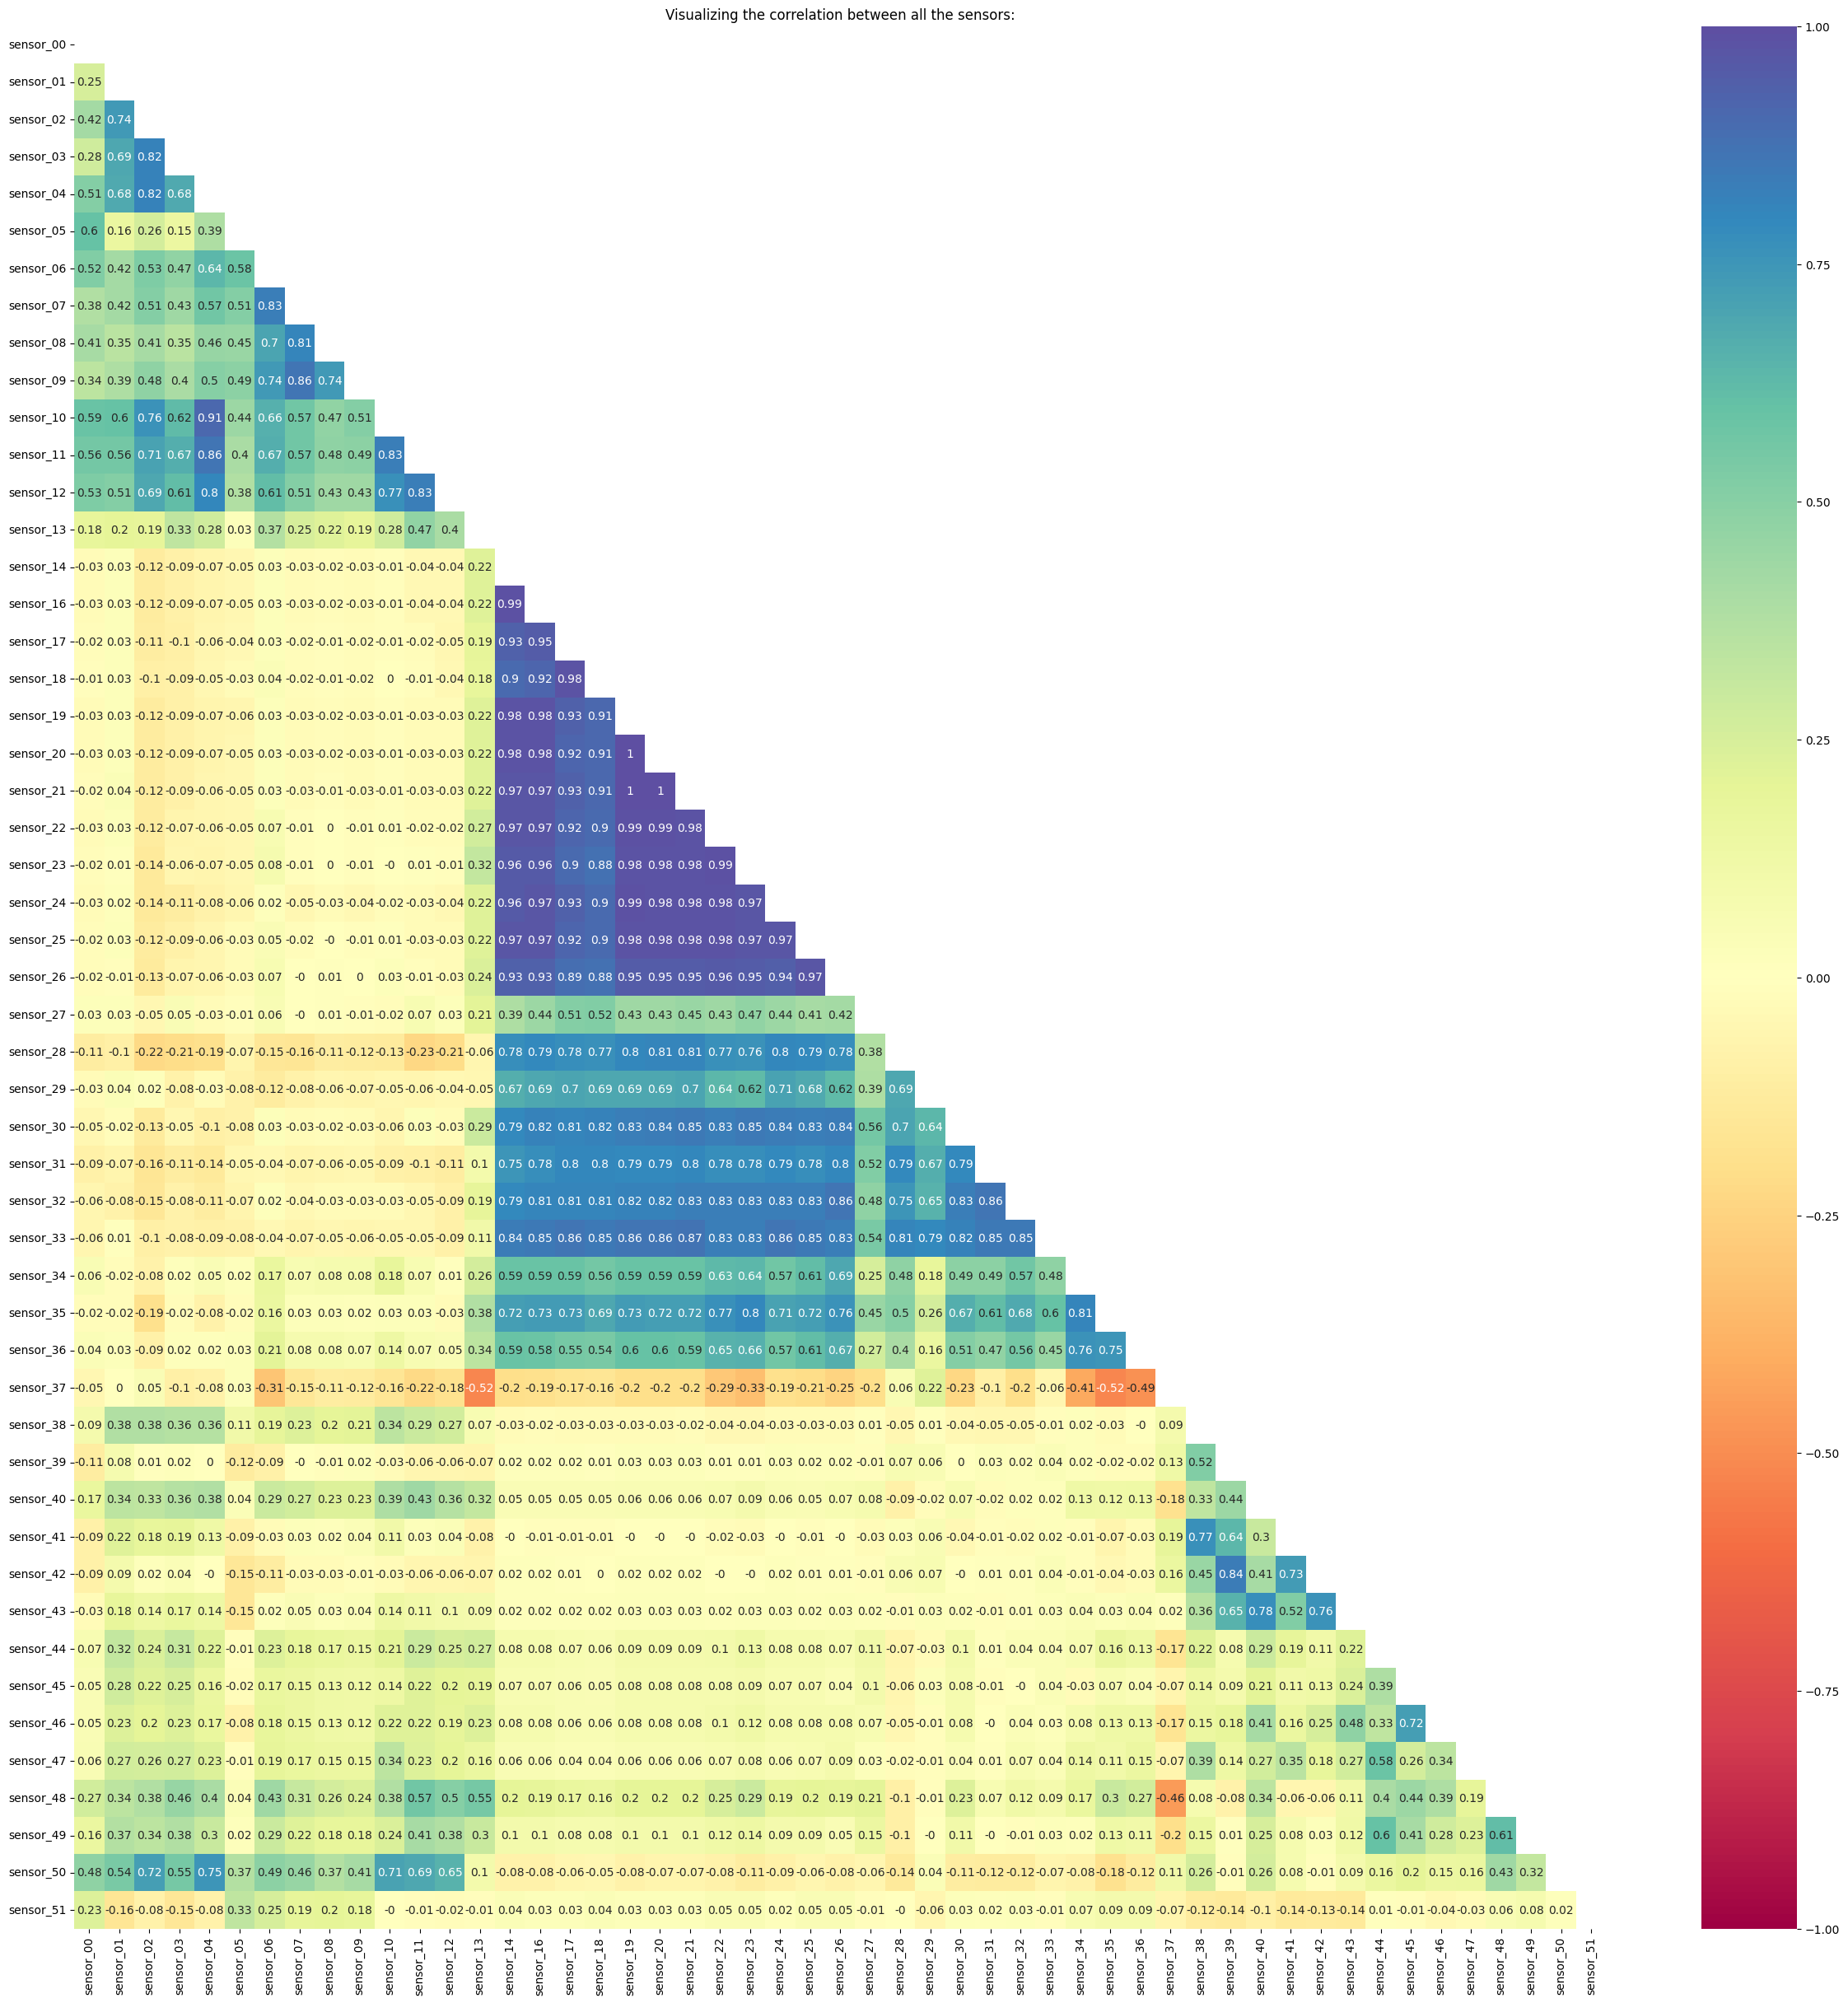

In [ ]:
#Correlation between sensors
#We will be using only the lower triangle from the correlation matrix to avoid redundancy
df_corr_lt = Cleaned_df.corr().where(np.tril(np.ones(Cleaned_df.corr().shape),k=-1).astype(np.bool))
df_corr_lt=round(df_corr_lt,ndigits=2)
plt.figure(figsize=(30,30))
sns.heatmap(df_corr_lt,cmap="Spectral", vmin=-1.0, vmax=1.0,annot=True)
plt.title("Visualizing the correlation between all the sensors:")

The dataset contains sensor data for 52 (now 51 after removing sensor 15) sensors, the timestamp of when this data was captured, and the status of the machine.

"machine_status" is our Target variable.

Strong positive correlation implies that the sensors have readings which are similar, where as negative correlation implies that the readings are inversely propoertional.

Sensors 16-26 seem to have high positive correlation where as sensors 37 has high negative correlation with sensors 13, 34, 35 and 36. Sensor 48 has high negative correlation with sensor 37.

We plan on further exploration of the potential impact of the correlation between sensors.


In [ ]:
Cleaned_df.shape

(219521, 52)

Now let's check the distribution of the values to check if they are all on the same scale

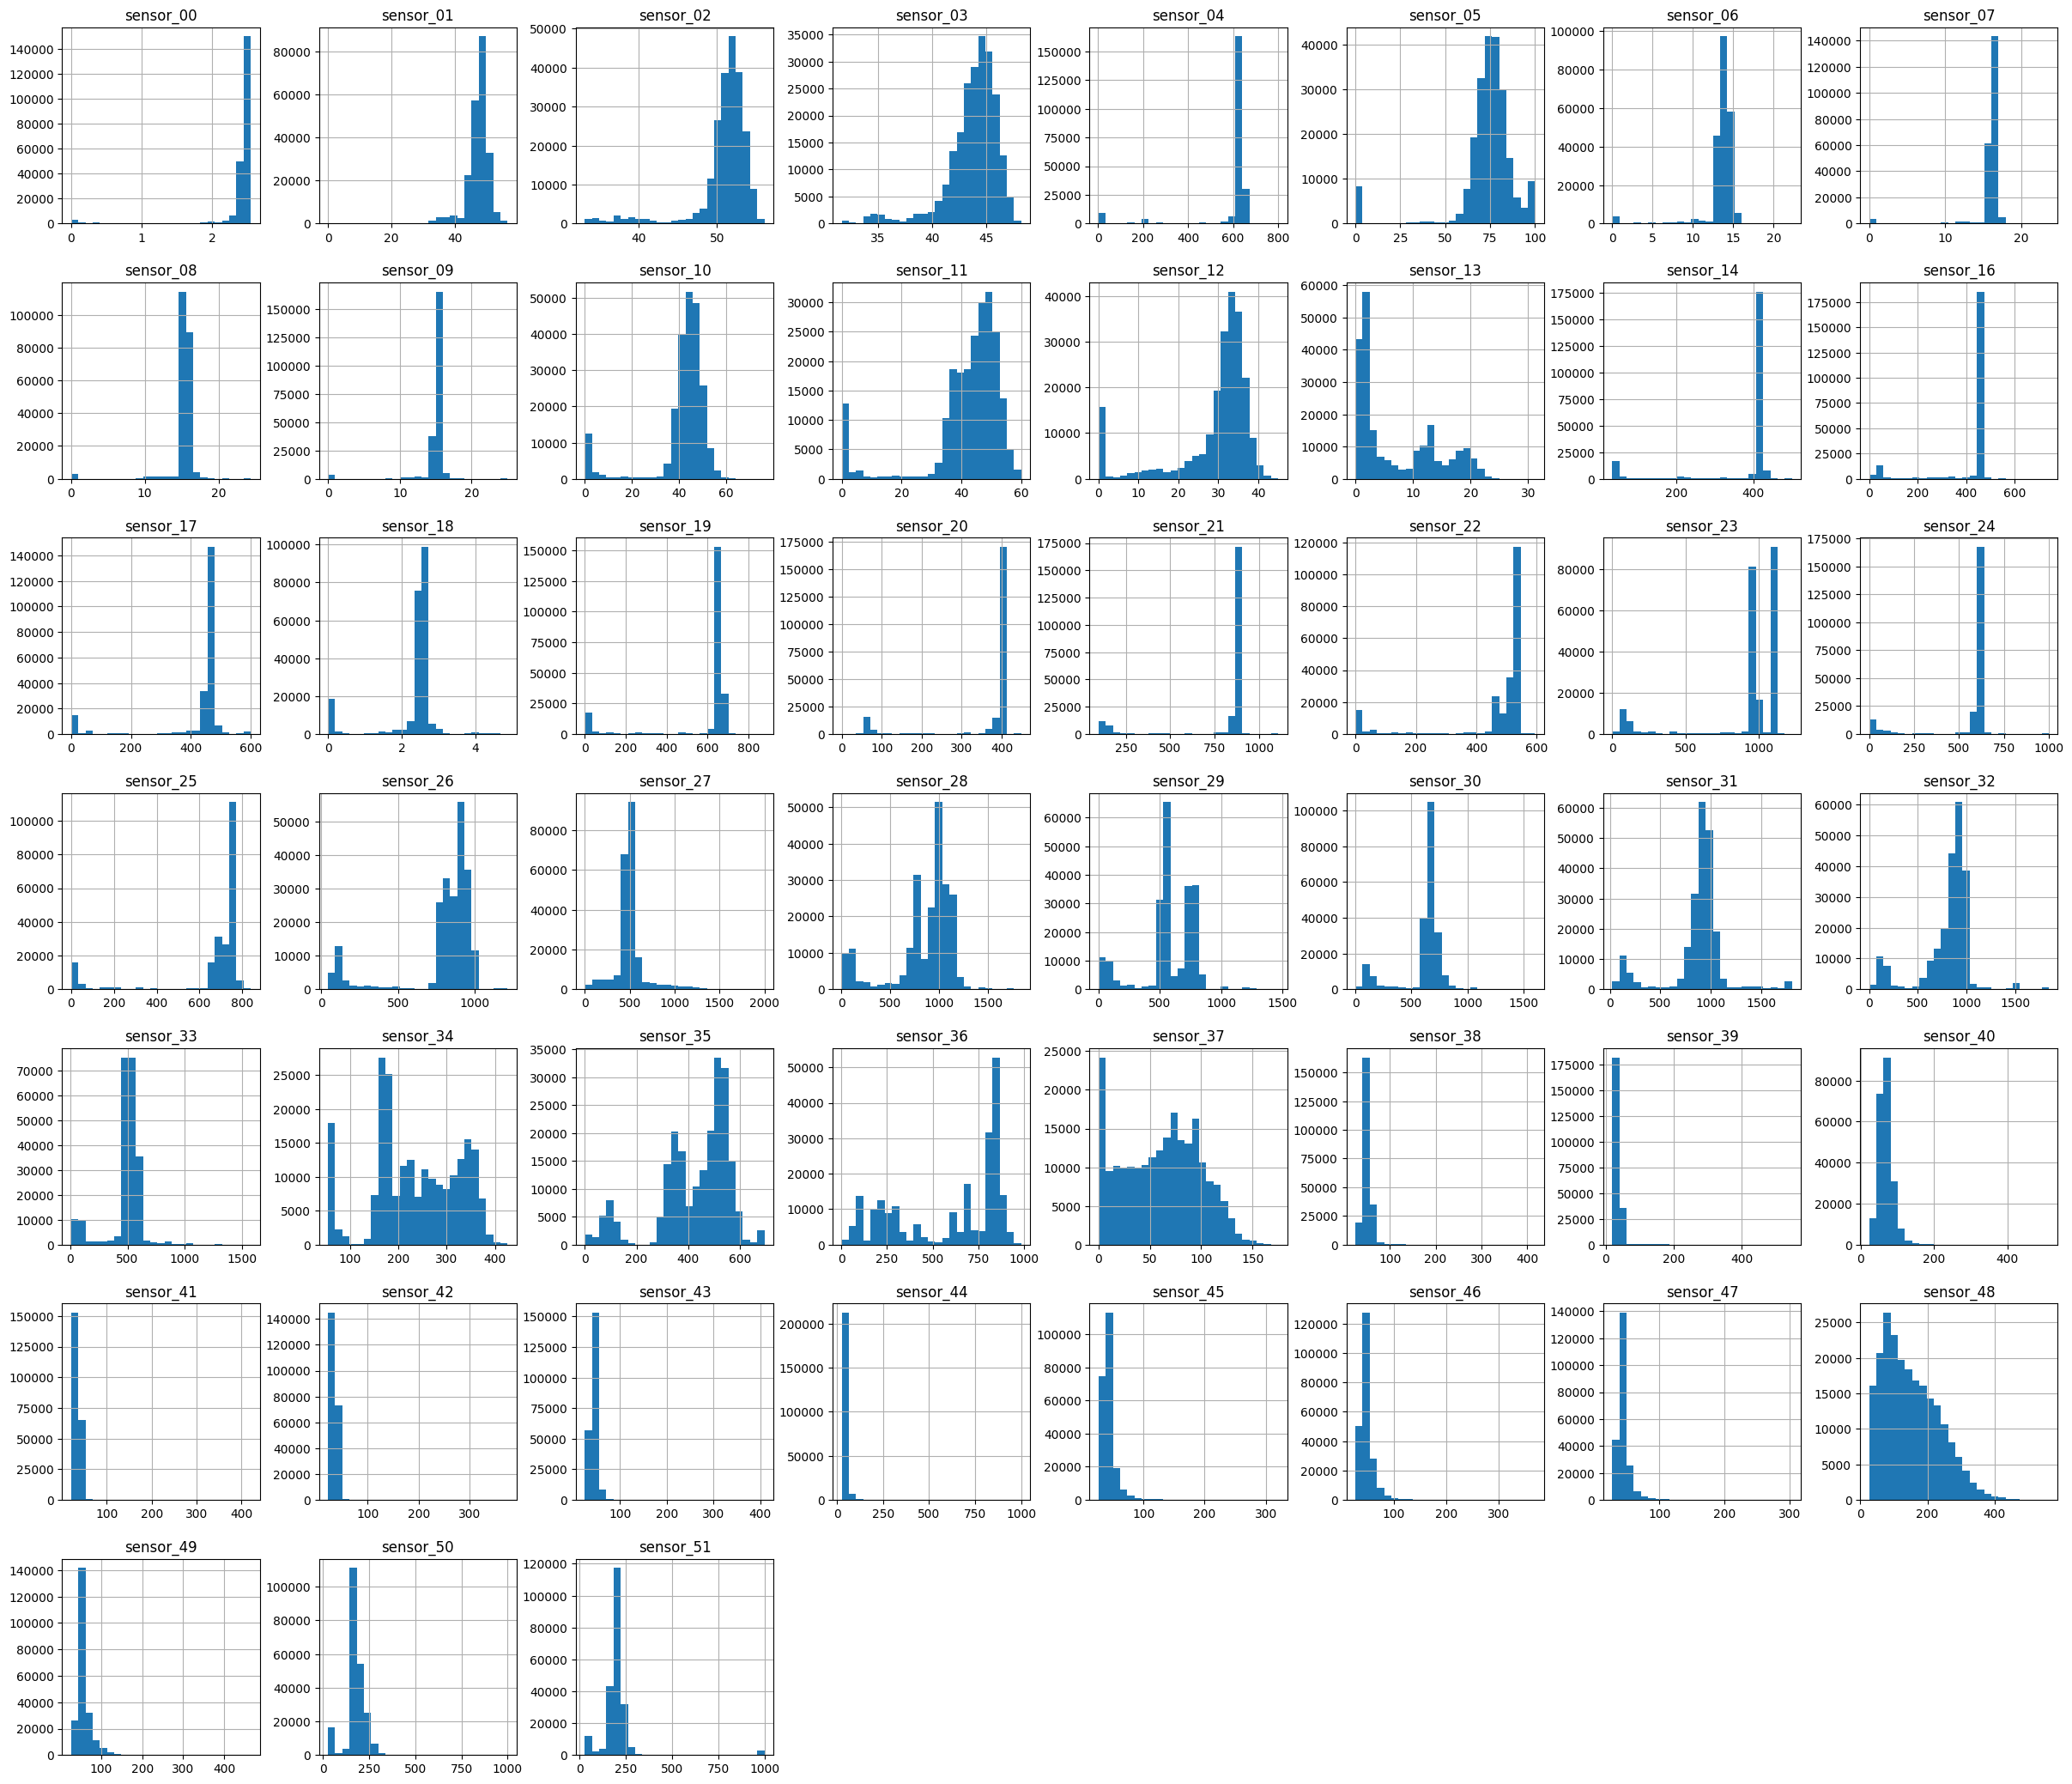

In [ ]:
# Histogram
Cleaned_df.hist(Cleaned_df.columns, bins=25, layout=(8,8), figsize=(30, 30))
plt.show()

It seems the variables don't follow the same scale for it's measurements, we'll make the necessary adjustments in the next steps.

## Variable Reduction and Scalability

In this step, we'll perform data scaling and utilize Principal Component Analysis (PCA) to identify and extract key features for subsequent model training. The reason why we're doing this is because running our models with 52 variables might take a lot of time since it's a lot of computation. In Addition, most variables might not have a large impact on our predictions.

In [ ]:
variable_red_df = Cleaned_df.drop(['machine_status'], axis=1)
names = variable_red_df.columns
x = Cleaned_df[names]

scaler = StandardScaler()
pca = PCA()

pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

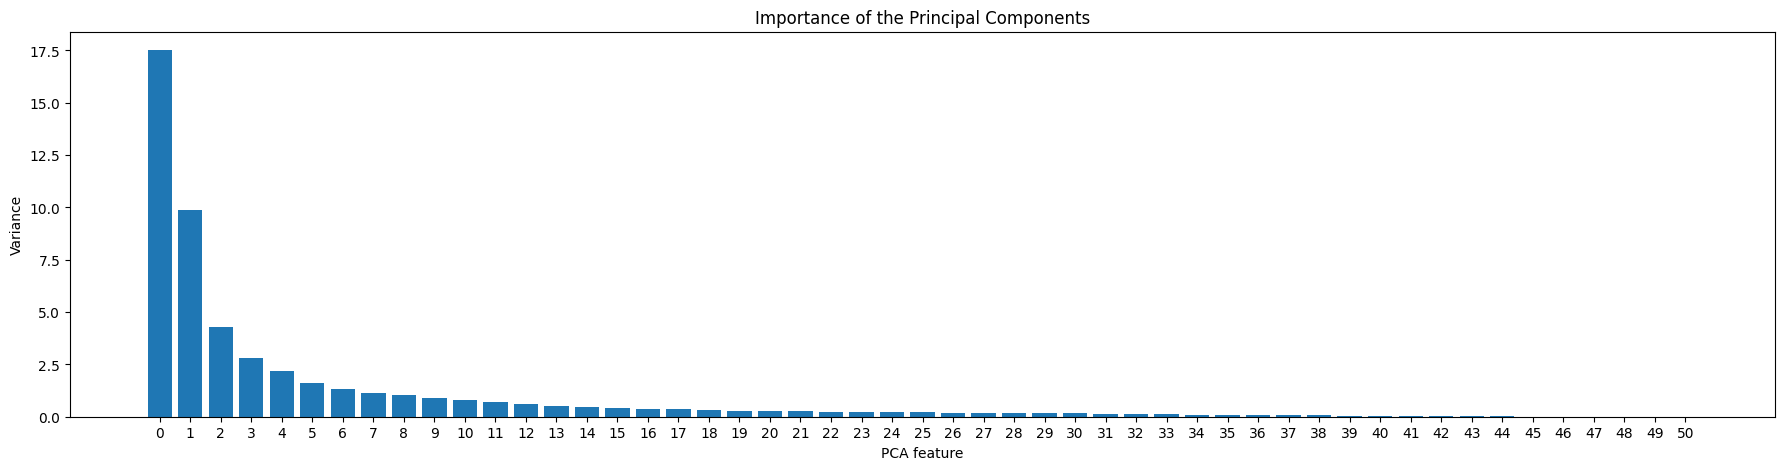

In [ ]:
features = range(pca.n_components_)
_ = plt.figure(figsize=(22, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components")
plt.show()

In [ ]:
# 2 components represent 75% of the variance
# Calculate PCA with 2 components
pca = PCA(n_components=2)
MainComponents = pca.fit_transform(x)
MainDF = pd.DataFrame(data = MainComponents, columns = ['pc1', 'pc2'])

In [ ]:
Cleaned_df['pc1']=pd.Series(MainDF['pc1'].values, index=Cleaned_df.index)
Cleaned_df['pc2']=pd.Series(MainDF['pc2'].values, index=Cleaned_df.index)

In [ ]:
Cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219521 entries, 2018-04-01 00:00:00 to 2018-08-31 23:59:00
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       219521 non-null  float64
 1   sensor_01       219521 non-null  float64
 2   sensor_02       219521 non-null  float64
 3   sensor_03       219521 non-null  float64
 4   sensor_04       219521 non-null  float64
 5   sensor_05       219521 non-null  float64
 6   sensor_06       219521 non-null  float64
 7   sensor_07       219521 non-null  float64
 8   sensor_08       219521 non-null  float64
 9   sensor_09       219521 non-null  float64
 10  sensor_10       219521 non-null  float64
 11  sensor_11       219521 non-null  float64
 12  sensor_12       219521 non-null  float64
 13  sensor_13       219521 non-null  float64
 14  sensor_14       219521 non-null  float64
 15  sensor_16       219521 non-null  float64
 16  sensor_17       219521

### Check Stationary and Correlation

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Test stationarity for pc1 and pc2
test_stationarity(Cleaned_df['pc1'])
test_stationarity(Cleaned_df['pc2'])

Results of Dickey-Fuller Test:
Test Statistic                     -4.799371
p-value                             0.000055
#Lags Used                         82.000000
Number of Observations Used    219438.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64
Results of Dickey-Fuller Test:


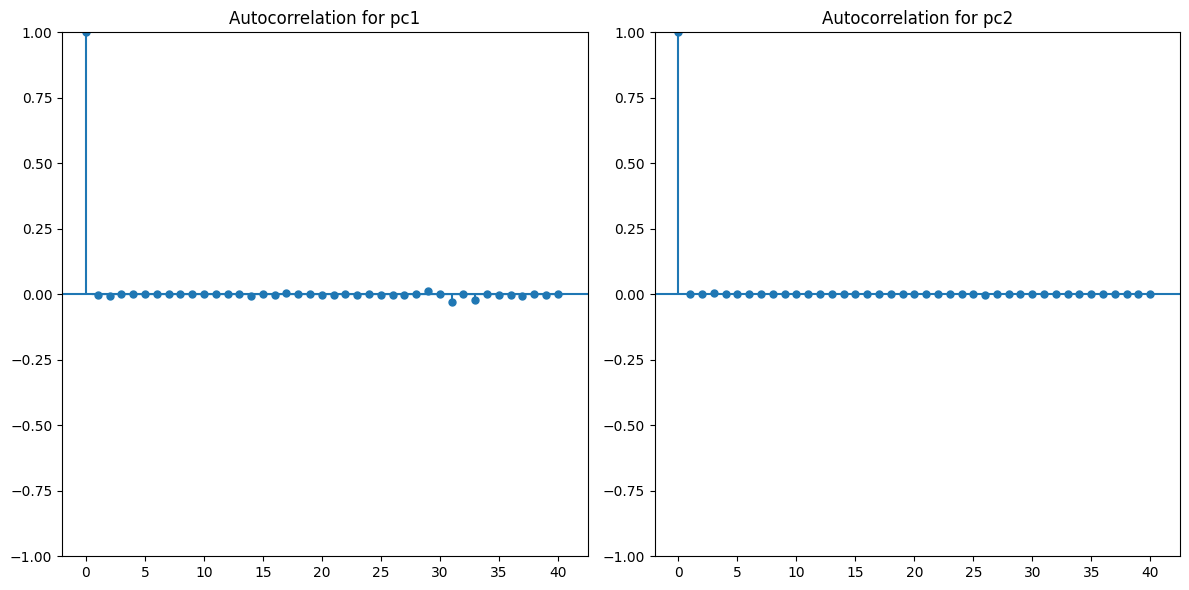

In [ ]:
# Plot Autocorrelation for pc1 and pc2

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Number of PCA variables
num_pca_vars = 2
# Setting up the figure for plotting
fig, axes = plt.subplots(nrows=1, ncols=num_pca_vars, figsize=(12, 6))  # Adjust the size as needed

# Iterate through each PCA variable
for i in range(num_pca_vars):
    pca_var = f'pc{i+1}'
    pca_data = MainDF[pca_var].pct_change()

    # Plotting the Autocorrelation for each PCA variable
    sm.graphics.tsa.plot_acf(pca_data.dropna(), lags=40, alpha=0.05, ax=axes[i])
    axes[i].set_title(f'Autocorrelation for {pca_var}')

plt.tight_layout()
plt.show()

We can see that both "pc1" and "pc2" are stationary time series. Since the p-values are 0.000055 for "pc1" and 0.000002 for "pc2", both of which are significantly less than 0.05, suggesting that the null hypothesis can be rejected.

And they also don't have any significant autocorrelation, which means we can proceed with our models

A machine can have three possible statuses: Normal, Recovering and Broken.

There are very few "broken" in the dataset compared to the number of normal and recovering machines. Which means we are dealing with heavily imbalanced data, once we start running the models, we will explanin how we plan on measuring the accuaracy of each.

Given this imbalance, we will consider the  categories "Broken" and "Recovering" as one class that we'll call "Anomaly".

In [ ]:
Cleaned_df['machine_status'].value_counts(dropna=False).head()

NORMAL        205067
RECOVERING     14447
BROKEN             7
Name: machine_status, dtype: int64

In [ ]:
Cleaned_df['new_status'] = Cleaned_df['machine_status'].apply(lambda x: 'Normal' if x == 'NORMAL' else 'Anomaly')
Cleaned_df['new_status'].value_counts(dropna=False).head()

Normal     205067
Anomaly     14454
Name: new_status, dtype: int64

## Statistical Modeling

### Base Model: Detect Outliers Using the Interquartile Range (IQR)

To calculate the percentage of anomalies we will define a upper and lower limit for our PCA variables, and set every outlier as anomalies.

We decided to use this as our base model because it's a simple strategy and does't require any model handeling, in our view, it would be the easiest way to predict possible failures.

In [ ]:
# outlier_lower = Q1 - (1.5*IQR)
# outlier_upper = Q3 + (1.5*IQR)
# Calculate outlier bounds for pc1
q1_pc1, q3_pc1 = Cleaned_df['pc1'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Calculate outlier bounds for pc2
q1_pc2, q3_pc2 = Cleaned_df['pc2'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
lower_pc2 = q1_pc2 - (1.5*iqr_pc2)
upper_pc2 = q3_pc2 + (1.5*iqr_pc2)

print("(", lower_pc1,"," , upper_pc1,")")
print("(", lower_pc2,"," , upper_pc2,")")

( -736.3329463390996 , 222.73590195336766 )
( -738.2364757059686 , 683.9742481802032 )


In [ ]:
# Creating the anomaly columns for each pca variable
Cleaned_df['anomaly_pc1_IQR'] = ((Cleaned_df['pc1']>upper_pc1) | (Cleaned_df['pc1']<lower_pc1)).astype('int')
Cleaned_df['anomaly_pc2_IQR'] = ((Cleaned_df['pc2']>upper_pc2) | (Cleaned_df['pc2']<lower_pc2)).astype('int')

# Replacing the integer values with strings
Cleaned_df['anomaly_pc1_IQR'] = Cleaned_df['anomaly_pc1_IQR'].map({0: 'Normal', 1: 'Anomaly'})
Cleaned_df['anomaly_pc2_IQR'] = Cleaned_df['anomaly_pc2_IQR'].map({0: 'Normal', 1: 'Anomaly'})

# Now printing the value counts
anomaly_pc1_counts = Cleaned_df['anomaly_pc1_IQR'].value_counts()
anomaly_pc2_counts = Cleaned_df['anomaly_pc2_IQR'].value_counts()

print(anomaly_pc1_counts)
print(anomaly_pc2_counts)

Normal     189644
Anomaly     29877
Name: anomaly_pc1_IQR, dtype: int64
Normal     217947
Anomaly      1574
Name: anomaly_pc2_IQR, dtype: int64


In [ ]:
# Creating a new column 'combined_status'
Cleaned_df['combined_anomalies_IQR'] = np.where((Cleaned_df['anomaly_pc1_IQR'] == 'Anomaly') |
                                         (Cleaned_df['anomaly_pc2_IQR'] == 'Anomaly'),
                                         'Anomaly', 'Normal')

# Now printing the value counts for the combined status
combined_anomaly_counts = Cleaned_df['combined_anomalies_IQR'].value_counts()
print(combined_anomaly_counts)


Normal     188836
Anomaly     30685
Name: combined_anomalies_IQR, dtype: int64


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Getting the true and predicted labels
true_labels = Cleaned_df['new_status']
predicted_labels = Cleaned_df['combined_anomalies_IQR']

# Generating the confusion matrix
conf_matrix_IQR = confusion_matrix(true_labels, predicted_labels, labels=['Normal', 'Anomaly'])

TN = conf_matrix_IQR[0][0]
TP = conf_matrix_IQR[1][1]
FN = conf_matrix_IQR[1][0]
FP = conf_matrix_IQR[0][1]

# Calculating accuracy for each class
accuracy_normal = TN / (TN + FP) * 100
accuracy_anomaly = TP / (TP + FN) * 100

# Calculating precision and recall
precision = precision_score(true_labels, predicted_labels, pos_label='Anomaly')
recall = recall_score(true_labels, predicted_labels, pos_label='Anomaly')

# Calculating F1 score
f1 = f1_score(true_labels, predicted_labels, pos_label='Anomaly')

print("Confusion Matrix:\n", conf_matrix_IQR)
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy for class 'Normal': {accuracy_normal:.2f}%")
print(f"Accuracy for class 'Anomaly': {accuracy_anomaly:.2f}%")


[[175837  29230]
 [ 12999   1455]]
Accuracy for class 'Normal': 85.75%
Accuracy for class 'Anomaly': 10.07%


### Model 2: Logistic Regression

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Select only the PCA features (pc1 and pc2) and the target variable
X = Cleaned_df[['pc1', 'pc2']]  # Features
y = Cleaned_df['new_status']  # Target variable

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# Create a pipeline that first scales the data and then applies logistic regression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, class_weight='balanced'))

# Perform 7-fold cross-validation and get predictions
y_pred_L = cross_val_predict(pipeline, X, y_encoded, cv=7)

# Calculate and print the confusion matrix
cm_LR = confusion_matrix(y_encoded, y_pred_L)
print("Confusion Matrix:\n", cm_LR)

# Displaying the results
class_accuracy_LR = 100 * cm_LR.diagonal() / cm_LR.sum(axis=1)

class_labels = label_encoder.classes_
for i, accuracy in enumerate(class_accuracy_LR):
    print(f"Accuracy for class '{class_labels[i]}' ({i}): {accuracy:.2f}%")

Confusion Matrix:
 [[ 11755   2699]
 [ 52099 152968]]
Accuracy for class 'Anomaly' (0): 81.33%
Accuracy for class 'Normal' (1): 74.59%


### Model 3: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and train the Random Forest model
# Adjust n_estimators, max_depth etc. as needed
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred_RF = cross_val_predict(rf_model, X_scaled, y_encoded, cv=7)

# Calculate and print the confusion matrix
cm_RF = confusion_matrix(y_encoded, y_pred_RF)
print("Confusion Matrix:\n", cm_RF)

# Displaying the results
class_accuracy_RF = 100 * cm_RF.diagonal() / cm_RF.sum(axis=1)

class_labels = label_encoder.classes_
for i, accuracy in enumerate(class_accuracy_RF):
    print(f"Accuracy for class '{class_labels[i]}' ({i}): {accuracy:.2f}%")


Confusion Matrix:
 [[  5802   8652]
 [ 16422 188645]]
Accuracy for class 'Anomaly' (0): 40.14%
Accuracy for class 'Normal' (1): 91.99%


### Model 4: Multivariate Gaussian Distribution

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score,confusion_matrix

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def select_threshold(probs, test_data):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(test_data, predictions, average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon

    return best_f1, best_epsilon

In [ ]:
# To run this model we decided to include a few more PCA variables to get better results.

pca2 = PCA(0.9)
principalComponents2 = pca2.fit_transform(x)
principalDf2 = pd.DataFrame(data = principalComponents2, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

In [ ]:
principalDf2['machine_status'] = pd.Series(Cleaned_df['machine_status'].values, index=principalDf2.index)
principalDf2['anomaly']= np.where(principalDf2['machine_status'] == 'NORMAL', False, True)

X_train_MGD, X_test_MGD, y_train_MGD, y_test_MGD = train_test_split(principalDf2.iloc[:,0:5],principalDf2['anomaly'],test_size=0.20, random_state=42)

mu, sigma = estimate_gaussian(X_train_MGD)
p_tr = multivariate_gaussian(X_train_MGD,mu,sigma)
p_ts = multivariate_gaussian(X_test_MGD,mu,sigma)

fscore, ep = select_threshold(p_ts,y_test_MGD)
print(fscore, ep)

0.6024551463644947 1.7111337393427953e-17


In [ ]:
p_all = multivariate_gaussian(principalDf2.iloc[:,0:5],mu,sigma)

principalDf2['anomaly2'] = (p_all < ep).astype(int)

principalDf2['anomaly2'].value_counts()

0    202033
1     17488
Name: anomaly2, dtype: int64

In [ ]:
# Generate the confusion matrix
cm_MGD = confusion_matrix(principalDf2['anomaly'], principalDf2['anomaly2'])

# True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP)
TN, FP, FN, TP = cm_MGD.ravel()

# Calculate accuracy for each class
accuracy_normal = TN / (TN + FP)  # Accuracy for class 'Normal' (0)
accuracy_anomaly = TP / (TP + FN) # Accuracy for class 'Anomaly' (1)

# Print the results

print("Confusion Matrix:\n", cm_MGD)
print(f"Accuracy for class 'Normal' (0): {accuracy_normal * 100:.2f}%")
print(f"Accuracy for class 'Anomaly' (1): {accuracy_anomaly * 100:.2f}%")

Confusion Matrix:
 [[197174   7893]
 [  4859   9595]]
Accuracy for class 'Normal' (0): 96.15%
Accuracy for class 'Anomaly' (1): 66.38%


### Model 5: Gaussian mixture **models**

In [ ]:
# For this model we will continue using the 5 pca variables defined in the previous one.

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0,init_params='kmeans', n_init=7).fit(X_train_MGD,y_train_MGD)
y_pred_gm_test = gm.predict(principalDf2.iloc[:,0:5])

In [ ]:
# Generate the confusion matrix
cm_GMM = confusion_matrix(principalDf2['anomaly'], y_pred_gm_test)

# True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP)
TN, FP, FN, TP = cm_GMM.ravel()

# Calculate accuracy for each class
accuracy_normal = TN / (TN + FP)  # Accuracy for class 'Normal' (0)
accuracy_anomaly = TP / (TP + FN) # Accuracy for class 'Anomaly' (1)

# Print the results
print("Confusion Matrix:\n", cm_GMM)
print(f"Accuracy for class 'Normal' (0): {accuracy_normal * 100:.2f}%")
print(f"Accuracy for class 'Anomaly' (1): {accuracy_anomaly * 100:.2f}%")

Confusion Matrix:
 [[173992  31075]
 [ 12814   1640]]
Accuracy for class 'Normal' (0): 84.85%
Accuracy for class 'Anomaly' (1): 11.35%


Gaussian Mixture Models can also used to find the probablistic cluster assignments.
We will be using the predicted probabilities from the Gaussian Mixture Models to detect anomalies using the same threshold method as the Multivariate Gaussian Distribution model.

In [ ]:
probs_test = gm.predict_proba(principalDf2.iloc[:,0:5])

fscore_gm, ep_gm = select_threshold(probs_test[:,[0]],principalDf2['anomaly'])
print(fscore_gm, ep_gm)

0.07652499898129661 0.9989999999997515


In [ ]:
principalDf2['gm_anomaly'] = (p_all < ep).astype(int)
principalDf2['gm_anomaly'].value_counts()

0    202033
1     17488
Name: gm_anomaly, dtype: int64

In [ ]:
# Predict anomalies based on the threshold
principalDf2['gm_anomaly'] = (probs_test[:, 0] < ep_gm).astype(int)

# Generate the confusion matrix
cm_GMM_CA = confusion_matrix(principalDf2['anomaly'], principalDf2['gm_anomaly'])

# True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP)
TN, FP, FN, TP = cm_GMM_CA.ravel()

# Calculate accuracy for each class
accuracy_normal = TN / (TN + FP)  # Accuracy for class 'Normal' (0)
accuracy_anomaly = TP / (TP + FN) # Accuracy for class 'Anomaly' (1)

# Print the results
print("Confusion Matrix:\n", cm_GMM_CA)
print(f"Accuracy for class 'Normal' (0): {accuracy_normal * 100:.2f}%")
print(f"Accuracy for class 'Anomaly' (1): {accuracy_anomaly * 100:.2f}%")

Confusion Matrix:
 [[172317  32750]
 [ 12576   1878]]
Accuracy for class 'Normal' (0): 84.03%
Accuracy for class 'Anomaly' (1): 12.99%
